In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

% matplotlib inline

## Mnist Dataset Classification using Logistic Regression

Let's only use two digits to reduce the problem to binary classification because we are using Logistic Regression that is used for linearly separable problem.

### Input X
It is an array/matrix of **N** number of rows and **M** columns i.e. NXM matrix.

Each row represent a single data instance that is a single digit. Each row is a vector of length **M**. So, there are **M** feature for a single data instance.

[  
    [x00, x01, x02, ..., x0m],  
    [x10, x11, x12, ..., x1m],  
    [x20, x21, x22, ..., x2m],  
    ...,  
    ...  
    [xn0, xn1, xn2, ..., xnm]  
]  

### Target Y
Each image represent a certain digit from 0 to 9. So, we have labelled data for performing **Supervised Classification**.

Generally, we encode each label into **one-hot-binary-vector** of length **k**. **One-hot-label** is a vector of length equal to the number of classes and each element represents a single class. The vector contains value **1** in the element that represents the respective class it belongs to. Like:  
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] --> digit '0'  
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0] --> digit '1'  
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] --> digit '2'  
...  
...  
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1] --> digit '9'

### In our following example
- We will only be classifying only two digits: 0 and 1
- Each image is of 8x8 size
- After vectorizing, the resulting vector is of length 64. That is there are 64 pixels in the  image.
- Each pixel's value is in the range [0, 255]. Hence, each image is a grayscale image.
- Each image is labelled either 0 or 1 that represent a digit **zero** or **one**

In [2]:
# load only two-digits dataset by passing the argument '2'
digits = load_digits(2)
X = digits.data
Y = digits.target

print("Y :")
print("The shape of Y is : ", Y.shape)
print("1st 10 elements of Y is : ", Y[:10])

print("X: ")
print("The shape of X is : ", X.shape)
print("Each X is of shape : ", X[0].shape)
print("An example of X is : \n", X[2])
print("Its respective label is : ", Y[2])

Y :
The shape of Y is :  (360,)
1st 10 elements of Y is :  [0 1 0 1 0 1 0 0 1 1]
X: 
The shape of X is :  (360, 64)
Each X is of shape :  (64,)
An example of X is : 
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0. 11. 16.  8. 14.  6.  0.  0.  2.
 16. 10.  0.  9.  9.  0.  0.  1. 16.  4.  0.  8.  8.  0.  0.  4. 16.  4.
  0.  8.  8.  0.  0.  1. 16.  5.  1. 11.  3.  0.  0.  0. 12. 12. 10. 10.
  0.  0.  0.  0.  1. 10. 13.  3.  0.  0.]
Its respective label is :  0


An example of class 1

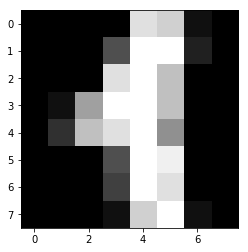

In [3]:
plt.imshow(X[3].reshape([8,8]), cmap="gray")

An example of class 0

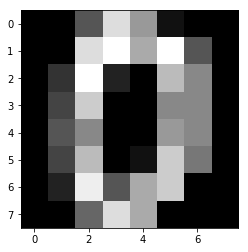

In [4]:
plt.imshow(X[0].reshape([8,8]), cmap="gray")

## Let's Use Hold Out Method
Instead of using all the training data, we use some major portion of it for training and remaining for testing the accuracy of the model. This is called **holdout** method.

So, we create **Train Set** and **Test Set**.

#### Train Set
Used for actually building the machine leanring model. It is generally 70% of total data instance.

#### Test Set
It is used for evaluating the built model. It is generally 30% of total data instance. That is:  
`test_set = whole_data - train_set`

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=42)

# Let's do it, alright!

First, we have to use sigmoid to predict the probability of a label.
$$
P(y=1|X) = \sigma(X \cdot W + b)
$$

Then, we have to calculate the error using **cross-entropy loss**. Cross entropy cost function is used for probabilistic distribution.  
  
  
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

### Note:
Generally, we use **softmax activation** instead of **sigmoid** with the cross-entropy loss because softmax activation distributes the probability througout each output node.  

But, since it is a binary classification, using sigmoid is same as softmax. For multi-class classification use sofmax with cross-entropy.

In case you are wondering why using sigmoid is identical to softmax for binary (single-class) classification, refer to this:  
https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons/207067#207067

In [6]:
# create global variables for weights and bias which have to be updated iteratively
weights = tf.Variable(dtype=tf.float32, initial_value=2*np.random.random((X.shape[1], 1))*0.001, name='weights')
b = tf.Variable(dtype=tf.float32, initial_value=1, name='b')

print(weights)
print(b)

<tf.Variable 'weights:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'b:0' shape=() dtype=float32_ref>


In [7]:
# create a dummy value representing x and y data
input_X = tf.placeholder(dtype=tf.float32, name='input_x')
input_Y = tf.placeholder(dtype=tf.float32, name='input_y')

print(input_X)
print(input_Y)

Tensor("input_x:0", dtype=float32)
Tensor("input_y:0", dtype=float32)


## Optimization

In a machine learning problem, the main goal is to minimize the error/loss. There are various ways to minimize the loss.

Generally, we try to find minima of the loss function. In a 2d space, we do it by finding the point where first derivative of that curve/function is zero.  

Example:

$$
y = (x-2)^2
$$

Here,
$$
dy/dx = 2 * (x-2)
$$

So, for finding minima
$$
dy/dx = 0
$$

$$
2 * (x-2) = 0
$$

$$
x = 2
$$

The scenario is similar in higher dimension. 

### But
The whole point of using machine learning is to find a **glorified curve** that really fits our data. So, we don't have enough power to ideally evaluate the curve to find that solution. That is why the straight-forward solution mentioned above is quite painful.

The weights are randomly initialized because we don't know the ideal values. So, we employ a certain method/technique that allows us to start from a random step and slowly move towards  the minima.  

**model = f(w1, w2, w3, ..., wn)**

## Gradient Descent
It is one of the widely used method for optimization of a machine learning model. 

The game is like a hill-climbing race. We have to reach the top of a hill fast.
- we start from  a random point/position: `weight = w0`
- we find the **most-steep** direction. This is done using a gradient since a gradient points to the direction of steepest ascent.
- We take a small step in that direction. We reach a new position.
- On this new position we repeat the process until we are no longer pointing anywhere.

So, gradient descent is like this but imagine it to be inverted  hill and you have to find the bottom of that hill.
So, instead of going in the direction of the  gradient, we move in the opposite direction to it.

$$
w new = w old - rate * gradient
$$

In [8]:
predicted_y = tf.squeeze(tf.nn.sigmoid(tf.add( tf.matmul(input_X, weights) , b)))
print(predicted_y)

loss = -tf.reduce_mean(input_Y*tf.log(predicted_y) + (1-input_Y)*tf.log(1-predicted_y))
print(loss)

optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
print(optimizer)

Tensor("Squeeze:0", dtype=float32)
Tensor("Neg:0", dtype=float32)
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_b/ApplyGradientDescent"



## Run The Graph In A Session

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5):
        sess.run(optimizer, {input_X: X_train, input_Y: Y_train})
        loss_i = sess.run(loss, {input_X: X_train, input_Y: Y_train})
        print("loss at iter %i: %.4f" % (i, loss_i))
        print("train auc:", roc_auc_score(Y_train, sess.run(predicted_y, {input_X:X_train})))
        print("test auc:", roc_auc_score(Y_test, sess.run(predicted_y, {input_X:X_test})))

loss at iter 0: 2.2119
train auc: 0.9950592885375493
test auc: 0.999505928853755
loss at iter 1: 1.5132
train auc: 0.999505928853755
test auc: 0.9990118577075099
loss at iter 2: 0.3817
train auc: 1.0
test auc: 1.0
loss at iter 3: 0.0110
train auc: 1.0
test auc: 1.0
loss at iter 4: 0.0104
train auc: 1.0
test auc: 1.0
